<a href="https://colab.research.google.com/github/blancavazquez/PLN/blob/main/notebooks/Embeddings_Familia_Simpsons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gensim

In [2]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import spacy  # For preprocessing
import numpy
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/MyDrive/1 IIMAS Mérida/Docs/2025_Clase_PLN/Slides/simpsons_dataset.csv')
print("Tamaño de la base de datos", df.shape)

Tamaño de la base de datos (158314, 2)


In [5]:
df.head()

raw_character_text                                       spoken_words
0              Miss Hoover  No, actually, it was a little of both. Sometim...
1             Lisa Simpson                             Where's Mr. Bergstrom?
2              Miss Hoover  I don't know. Although I'd sure like to talk t...
3             Lisa Simpson                         That life is worth living.
4  Edna Krabappel-Flanders  The polls will be open from now until the end ...

In [6]:
#Eliminando datos ausentes
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

## Preprocesamiento

In [7]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed
def cleaning(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    if len(txt) > 2:
        return ' '.join(txt)

In [8]:
#Removiendo caracteres especiales
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

In [9]:
# Pipeline de spacy
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 2.43 mins


In [10]:
# Se almacenan los resultados en un dataframe
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(85952, 1)

In [11]:
## Trabajando n-gramas
from gensim.models.phrases import Phrases, Phraser
sent = [row.split() for row in df_clean['clean']]
print("Tipo:", type(sent), "\n", sent)

Tipo: <class 'list'> 
 [['actually', 'little', 'disease', 'magazine', 'news', 'show', 'natural', 'think'], ['know', 'sure', 'like', 'talk', 'touch', 'lesson', 'plan', 'teach'], ['life', 'worth', 'live'], ['poll', 'open', 'end', 'recess', 'case', 'decide', 'thought', 'final', 'statement', 'martin'], ['victory', 'party', 'slide'], ['mr', 'bergstrom', 'mr', 'bergstrom'], ['hey', 'hey', 'move', 'morning', 'new', 'job', 'take', 'copernicus', 'costume'], ['think', 'take', 'train', 'capital', 'city'], ['train', 'like', 'traditional', 'environmentally', 'sound'], ['yes', 'backbone', 'country', 'leland', 'stanford', 'drive', 'golden', 'spike', 'promontory', 'point'], ['hey', 'thank', 'vote', 'man'], ['vote', 'voting', 'geek'], ['get', 'right', 'thank', 'vote', 'girl'], ['sweat', 'long', 'couple', 'people', 'right', 'milhouse'], ['martin', 'martin', 'like', 'recount'], ['want', 'sure', 'martin', 'martin'], ['way', 'mister', 'president'], ['board', 'track', 'afternoon', 'delight', 'come', 'shelby

In [12]:
#Crea frases relevantes a partir de la lista de oraciones:
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]

In [13]:
#Gensim Word2Vec Implementation
import multiprocessing
from gensim.models import Word2Vec

In [14]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size = 300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,)

In [15]:
#Connstruyendo la tabla de vocabulario
t = time()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.01 mins


In [16]:
#Training
t = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 1.0 mins


In [17]:
w2v_model.init_sims(replace=True)

/tmp/ipython-input-514372312.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


#Buscando elementos similares

In [18]:
w2v_model.wv.most_similar(positive=["homer"])

[('marge', 0.7348268032073975),
 ('sweetheart', 0.7187322378158569),
 ('depressed', 0.6802022457122803),
 ('bartender', 0.6734963655471802),
 ('snuggle', 0.6635269522666931),
 ('gee', 0.6599283218383789),
 ('becky', 0.6592552661895752),
 ('straighten', 0.6581301689147949),
 ('hammock', 0.6551150679588318),
 ('convince', 0.6543463468551636)]

In [19]:
w2v_model.wv.most_similar(positive=["homer_simpson"])

[('pleased', 0.7337966561317444),
 ('threat', 0.7209157347679138),
 ('council', 0.7122808694839478),
 ('select', 0.7094054222106934),
 ('easily', 0.708089292049408),
 ('defeat', 0.6982253789901733),
 ('surrender', 0.6891123652458191),
 ('robert', 0.6877651214599609),
 ('versus', 0.6821122169494629),
 ('indicate', 0.6798635125160217)]

In [20]:
w2v_model.wv.similarity('maggie', 'baby')

0.71167326

In [21]:
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])

'nelson'

In [22]:
w2v_model.wv.doesnt_match(['homer', 'patty', 'selma'])

'homer'

#Visualización

In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [24]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)

    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)


    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)

    plt.title('t-SNE visualization for {}'.format(word.title()))

Visualizando las palabras más cercanas a Homero y ¿qué pasa si comparamos con palabras random?


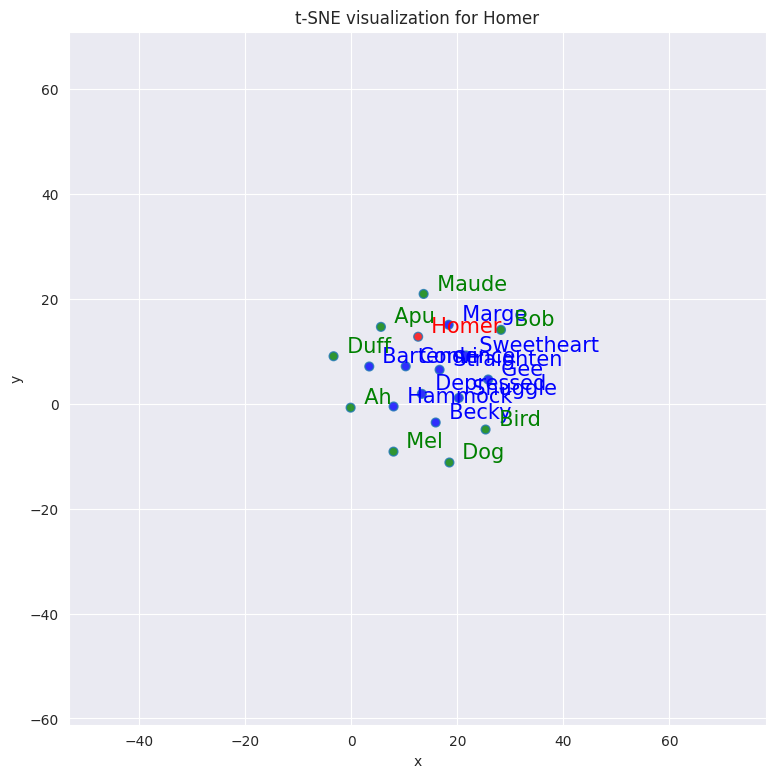

In [25]:
print("Visualizando las palabras más cercanas a Homero y ¿qué pasa si comparamos con palabras random?")
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

10 palabras más similares vs. 10 más diferentes


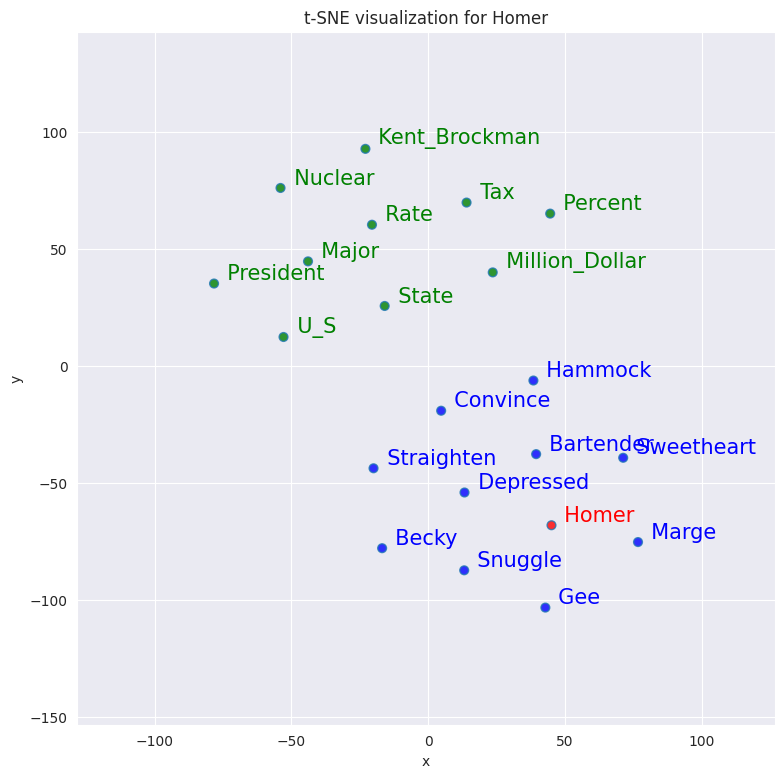

In [26]:
print("10 palabras más similares vs. 10 más diferentes")
tsnescatterplot(w2v_model, 'homer', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])])

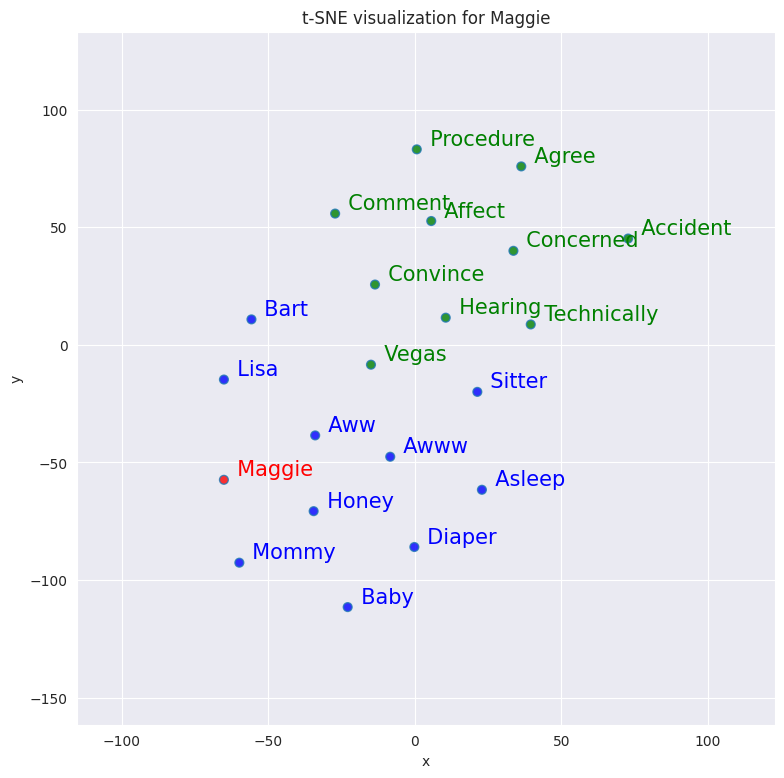

In [28]:
tsnescatterplot(w2v_model, "maggie", [t[0] for t in w2v_model.wv.most_similar(positive=["mr_burn"], topn=20)][10:])